# EMNIST (Handwritten Characters)

## Data

There are six different splits provided in this dataset:

* EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
* EMNIST ByMerge: 814,255 characters. 47 unbalanced classes.
* EMNIST Balanced:  131,600 characters. 47 balanced classes.
* EMNIST Letters: 145,600 characters. 26 balanced classes.
* EMNIST Digits: 280,000 characters. 10 balanced classes.
* EMNIST MNIST: 70,000 characters. 10 balanced classes.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to convert the images to tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Download and load the EMNIST dataset (Balanced split)
emnist_train = datasets.EMNIST(
    root='./data',
    split='balanced',
    train=True,
    transform=transform,
    download=True
)

emnist_test = datasets.EMNIST(
    root='./data',
    split='balanced',
    train=False,
    transform=transform,
    download=True
)

# Create data loaders for training and testing
train_loader = torch.utils.data.DataLoader(
    emnist_train,
    batch_size=64,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    emnist_test,
    batch_size=64,
    shuffle=False
)

100%|██████████| 562M/562M [00:10<00:00, 55.9MB/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


## EDA

In [5]:
print(f'Training set size: {len(train_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 112800
Test set size: 18800


In [6]:
classes = train_dataset.classes
print(f'Number of classes: {len(classes)}')
print('Classes:', classes)

Number of classes: 47
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [8]:
import torch
from torchvision import datasets, transforms
import torchvision.utils as utils
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

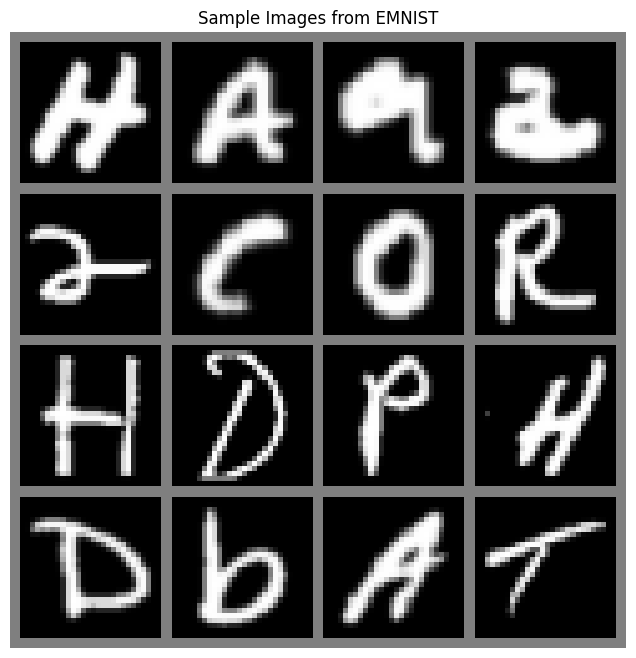

Labels: [42 10 44 36  2 12 24 27 17 13 25 17 13 37 10 29]


In [9]:
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Data loader for visualization
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

# Get a batch of images
images, labels = next(iter(data_loader))

# EMNIST images need to be rotated
images = images.permute(0, 1, 3, 2)

# Create a grid of images
img_grid = utils.make_grid(images, nrow=4, padding=2)

# Show images
imshow(img_grid, title='Sample Images from EMNIST')

# Print labels
print('Labels:', labels.numpy())

## Models

In [3]:
# CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input channels, output channels, kernel size
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Kernel size, stride

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 7 * 7, 1000),  # Adjust input size based on the output of conv layers
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 47)  # 47 classes in EMNIST Balanced split
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layer(x)
        return x

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5  # You can increase this for better accuracy
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # EMNIST images need to be rotated
        images = images.permute(0, 1, 3, 2)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.permute(0, 1, 3, 2)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/5], Loss: 0.7109
Epoch [2/5], Loss: 0.4267
Epoch [3/5], Loss: 0.3717
Epoch [4/5], Loss: 0.3360
Epoch [5/5], Loss: 0.3073
Test Accuracy: 88.24%


In [4]:
# Bi-LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_size=28, hidden_size=128, num_layers=2, num_classes=47):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # x shape: (batch_size, 1, 28, 28)
        x = x.squeeze(1)       # Now x shape: (batch_size, 28, 28)
        x = x.permute(0, 2, 1)  # Now x shape: (batch_size, 28, 28)
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BiLSTMModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')

# Testing loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Epoch [1/5], Loss: 0.9268
Epoch [2/5], Loss: 0.4534
Epoch [3/5], Loss: 0.3913
Epoch [4/5], Loss: 0.3519
Epoch [5/5], Loss: 0.3273
Test Accuracy: 86.78%


## Why RCNN and Faster R-CNN May Not Be Suitable:


EMNIST Dataset Characteristics:
* EMNIST images contain single, centered characters.
* There is no need for object localization since each image contains only one object.
* Applying RCNN or Faster R-CNN would be unnecessary and inefficient for this dataset.

## Evaluation

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.28      0.41       400
           1       0.52      0.77      0.62       400
           2       0.92      0.83      0.87       400
           3       0.96      0.98      0.97       400
           4       0.91      0.94      0.93       400
           5       0.92      0.89      0.90       400
           6       0.92      0.93      0.93       400
           7       0.94      0.98      0.96       400
           8       0.92      0.93      0.92       400
           9       0.65      0.89      0.75       400
          10       0.96      0.96      0.96       400
          11       0.95      0.95      0.95       400
          12       0.96      0.96      0.96       400
          13       0.90      0.90      0.90       400
          14       0.98      0.98      0.98       400
          15       0.69      0.60      0.64       400
          16       0.93      0.94      0.94       400
   

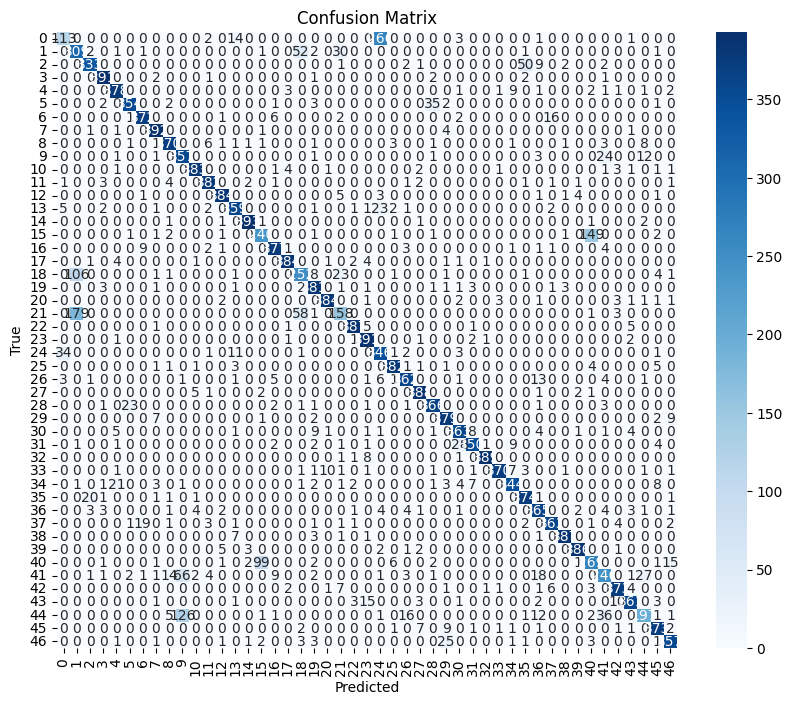

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to compute confusion matrix and classification report
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Classification Report:\n", classification_report(all_labels, all_preds))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(47), yticklabels=range(47))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Call this function after testing your model
evaluate_model(model, test_loader)

Epoch [1/5], Train Loss: 0.3046, Val Loss: 0.3701
Epoch [2/5], Train Loss: 0.2885, Val Loss: 0.3612
Epoch [3/5], Train Loss: 0.2737, Val Loss: 0.3706
Epoch [4/5], Train Loss: 0.2605, Val Loss: 0.3570
Epoch [5/5], Train Loss: 0.2466, Val Loss: 0.3624


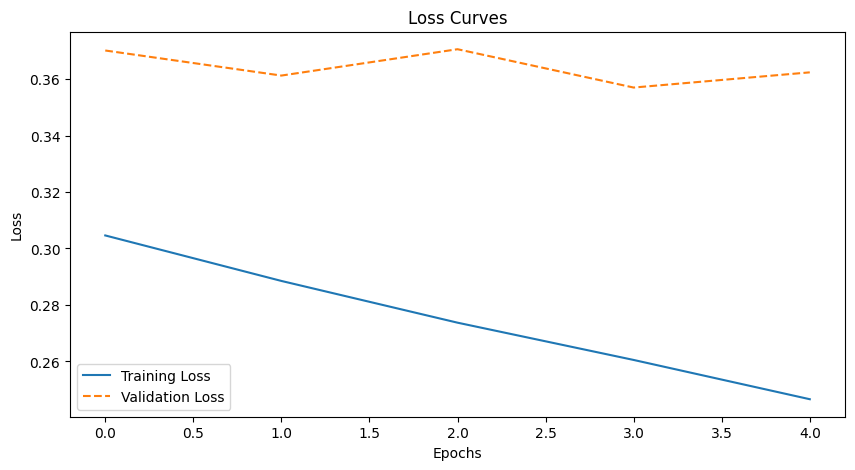

In [24]:
# Keep track of training and validation loss
train_losses = []
val_losses = []

# Modify your training loop to store losses
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Optionally, compute validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(test_loader))

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Easy OCR (Text OCR)

In [13]:
!pip install pytesseract pillow

In [17]:
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,681 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [22]:
from PIL import Image
import pytesseract
import cv2
import numpy as np
from difflib import SequenceMatcher

def preprocess_image(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        print(f"Error: Could not load image from path: {image_path}")
        raise ValueError("Image not loaded")

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply adaptive threshold to preprocess the image
    preprocessed_image = cv2.adaptiveThreshold(blurred, 255,
                                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                               cv2.THRESH_BINARY, 11, 2)
    return preprocessed_image

def perform_ocr(preprocessed_image):
    # Convert the preprocessed image to a format compatible with PIL
    pil_image = Image.fromarray(preprocessed_image)

    # Use pytesseract to do OCR on the preprocessed image
    text = pytesseract.image_to_string(pil_image)

    return text

def measure_accuracy(extracted_text, ground_truth):
    # Calculate the accuracy by comparing the extracted text to the ground truth
    matcher = SequenceMatcher(None, extracted_text, ground_truth)
    accuracy = matcher.ratio()
    return accuracy

def main():
    # Input image path
    image_path = input("Enter the path to the PNG image file: ")

    # Ground truth text (for accuracy measurement)
    ground_truth = input("Enter the ground truth text: ")

    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)

    # Perform OCR on the preprocessed image
    extracted_text = perform_ocr(preprocessed_image)

    # Measure accuracy
    accuracy = measure_accuracy(extracted_text, ground_truth)

    # Print the extracted text and accuracy
    print("Extracted Text:")
    print(extracted_text)
    print(f"Accuracy: {accuracy * 100:.2f}%")

if __name__ == "__main__":
    main()

Enter the path to the PNG image file: /content/life-quotes-wayne-dyer-1665420549.png
Enter the ground truth text: If you change the way you look at things, the things you look at change.
Extracted Text:
If you change the
way you Took at things,
the things you
Took at change. «31

    

Accuracy: 85.90%


Comments
* USE PNG
* /content/life-quotes-wayne-dyer-1665420549.png
* If you change the way you look at things, the things you look at change.